In [1]:
import sys
sys.path.append('../code')
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [52]:
start_num = 10 
total_iteration_num= 20000
exp_num = '2'

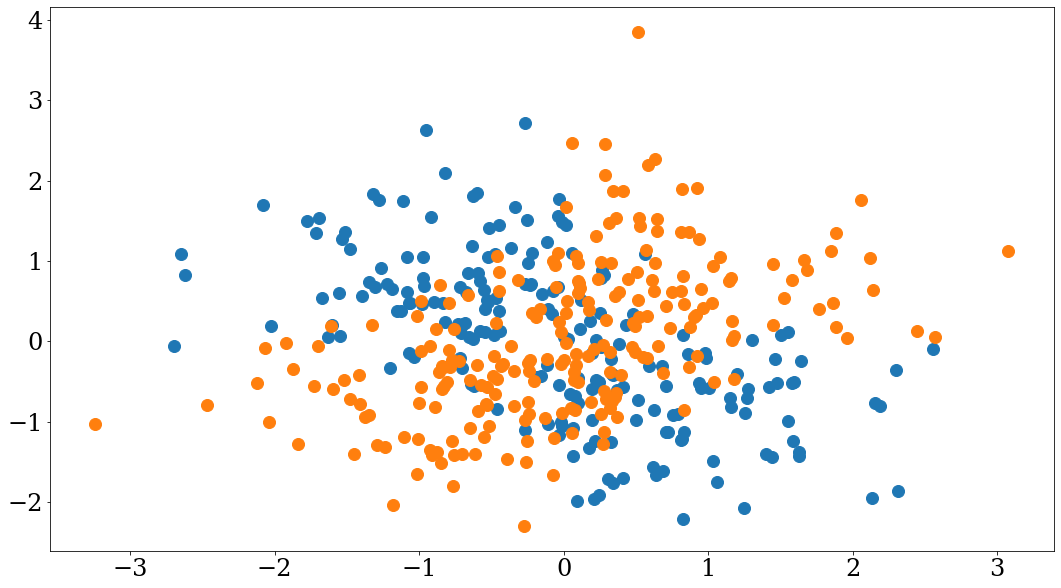

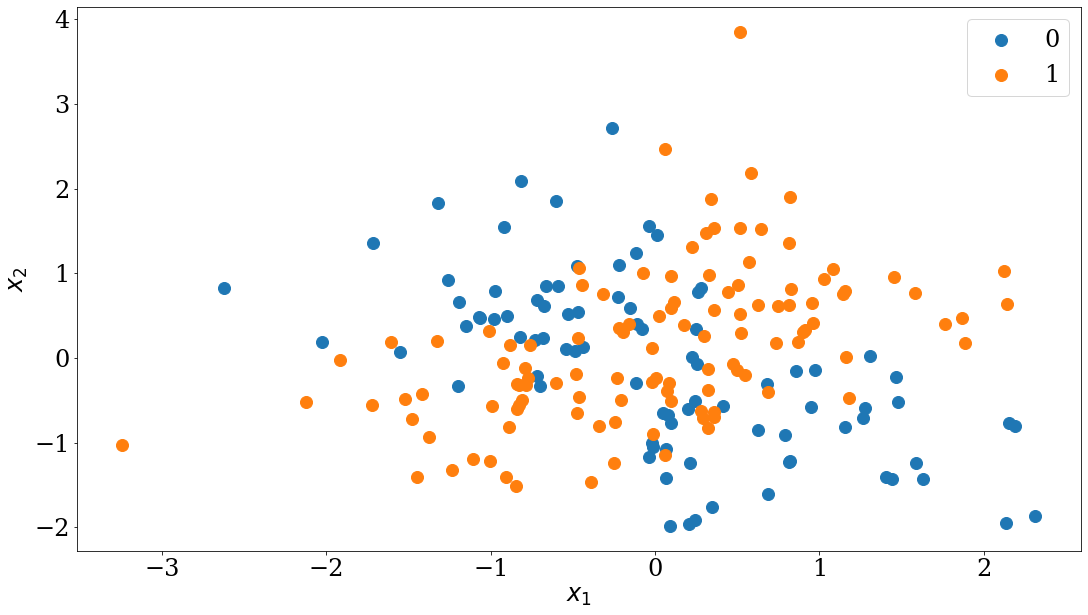

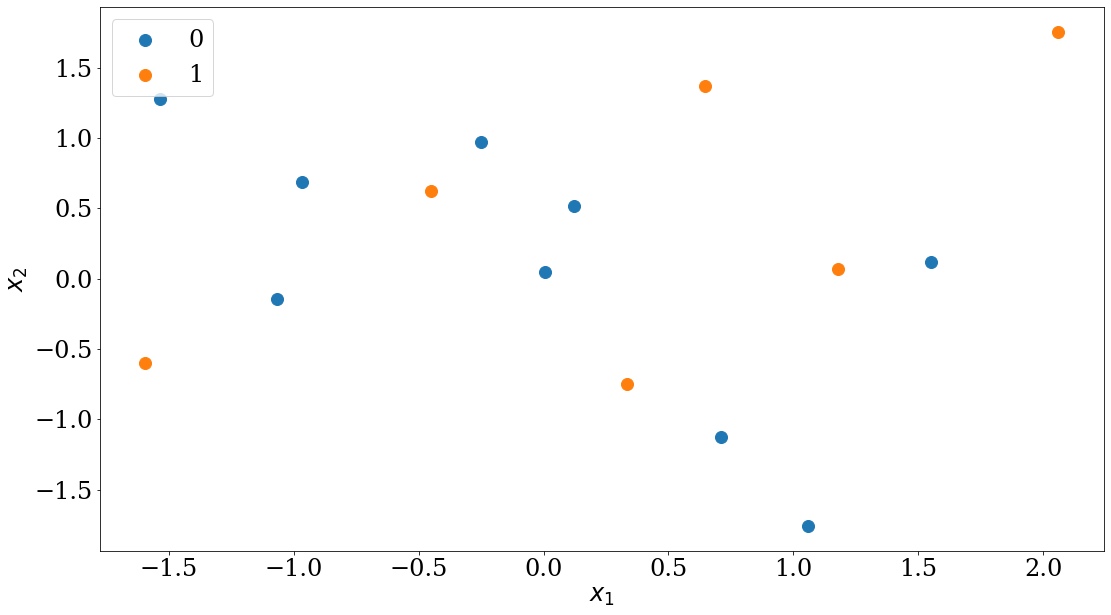

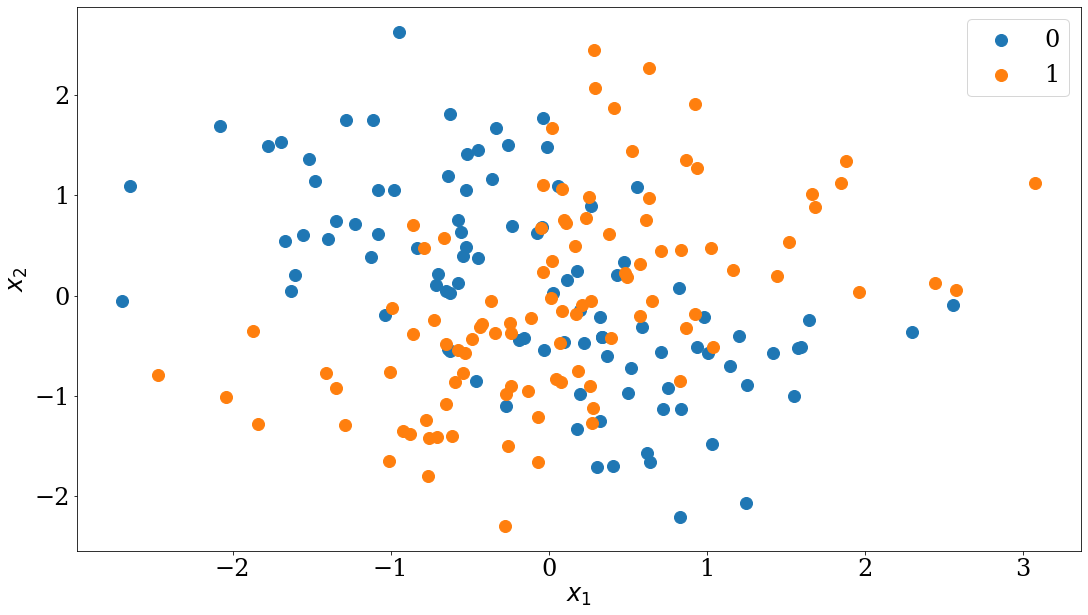

In [115]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='0')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('ttrain.pdf')
plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='0')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('train.pdf')
plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='0')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('test.pdf')
plt.legend()
plt.show()


In [ ]:
class LogReg(t.nn.Module):
    def __init__(self, idx):
        t.nn.Module.__init__(self)
        self.lin = t.nn.Linear(len(idx), 2) 
        self.idx = idx        
    
    def forward(self, x):
        return self.lin(x[:, self.idx])
    
        

In [5]:
def accuracy(student, x,y):
    student.eval()
    total = 0 
    correct = 0
    with t.no_grad():
        out = student(x)
        correct += t.eq(t.argmax(out, 1), y).sum()
        total+=len(x)
    student.train()
    return (correct/total).cpu().detach().numpy()

In [6]:
# обучение учителя
t.manual_seed(0)
teacher = LogReg([0,1,2])
optim = t.optim.Adam(teacher.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    teacher.zero_grad() 
    loss = crit(teacher(x_ttrain), y_ttrain)
    loss.backward()
    optim.step()    
    
    teacher.eval()
    if e%1000==0:
        print (accuracy(teacher, x_test, y_test ))    
    teacher.train()
    



0.5
0.66
0.665
0.69
0.69
0.69
0.69
0.69
0.69
0.69


In [7]:
# обучение студента без дистилляции
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    student.zero_grad()            
    loss = crit(student(x_train), y_train)
    loss.backward()
    optim.step()        
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    



0.48
0.69
0.725
0.745
0.76
0.755
0.755
0.755
0.755
0.755


In [8]:
kl = t.nn.KLDivLoss(reduction='batchmean')
sm = t.nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = t.nn.functional.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [ ]:
# полная дистилляция
beta1 = 0.0
beta2 = 1.0
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [ ]:
# дистилляция с разными коэффициентами
beta1 = 1.0
beta2 = .5
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [10]:
# дистилляция с оптимизацией гиперапарметров

def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for _ in range(start_num):
    results_opt = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        
        optim2.zero_grad()            
        hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))
        optim2.step()

        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()  
        student.train()       
        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                  float(F.sigmoid(beta2).detach().numpy()), 
                  float(10*F.sigmoid(temp).detach().numpy()))
            student.train()
            results_opt.append([e, 
                                float(accuracy(student, x_test, y_test)),
                                float(F.sigmoid(beta1).detach().numpy()),
                                float(F.sigmoid(beta2).detach().numpy()), 
                                float(10*F.sigmoid(temp).detach().numpy())])
    with open('exp'+exp_num+'_linear_exp_hyper_opt.jsonl','a') as out:
        out.write(json.dumps(results_opt)+'\n')
    
            

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.66 0.5501200556755066 0.5080268979072571 4.598002731800079
0.75 0.5164719223976135 0.574785590171814 5.006224513053894
0.755 0.5109174847602844 0.5810940265655518 4.677838683128357
0.76 0.5065059065818787 0.5833479166030884 4.120113849639893
0.77 0.5034774541854858 0.5846532583236694 3.1641754508018494
0.8 0.4688069224357605 0.6112420558929443 1.4762435853481293
0.815 0.2791707515716553 0.7282047867774963 0.8497366309165955
0.815 0.16486716270446777 0.7865158319473267 0.5788402631878853
0.825 0.11212377995252609 0.8134896755218506 0.44682346284389496
0.825 0.09034888446331024 0.8246333003044128 0.3884158656001091
0.825 0.08257738500833511 0.8284143209457397 0.36679811775684357
0.825 0.08024131506681442 0.8294720649719238 0.360211543738842
0.825 0.07966327667236328 0.8297167420387268 0.3585774078965187
0.825 0.07954386621713638 0.8297692537307739 0.3582386299967766
0.825 0.07952316850423813 0.8297865986824036 0.3581777960062027
0.825 0.07952138781547546 0.8297964334487915 0.3581703826

0.825 0.07989548146724701 0.833593487739563 0.35819776356220245
0.825 0.07988748699426651 0.8336061835289001 0.3581729158759117
0.825 0.0798867866396904 0.8336102366447449 0.3581700474023819
0.825 0.0798867866396904 0.8336106538772583 0.35816989839076996
0.825 0.07988667488098145 0.8336116075515747 0.35816945135593414
0.825 0.07988665997982025 0.8336141705513 0.35816844552755356
0.825 0.07988621294498444 0.8336211442947388 0.3581661731004715
0.825 0.07988664507865906 0.8336323499679565 0.35816412419080734
0.825 0.07988783717155457 0.8336449265480042 0.3581637889146805
0.825 0.07988888770341873 0.8336580991744995 0.3581634536385536
0.825 0.07989011704921722 0.8336708545684814 0.3581632673740387
0.35 0.7213858366012573 0.5702111721038818 4.120769798755646
0.6 0.7336174845695496 0.6890943050384521 3.6289355158805847
0.725 0.7329992651939392 0.7531135678291321 3.389430344104767
0.76 0.7197172045707703 0.7813458442687988 2.312125563621521
0.81 0.5698854327201843 0.8404813408851624 1.2130703

In [61]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху
# epoch_size = 10
# epoch_size = 100
# epoch_size = 500
# epoch_size = 1000
epoch_size = 2000


def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss


# results_opt = []
for _ in range(start_num):
    results_opt = []
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        e_ = e//epoch_size
        if e%epoch_size == 0 and e_ % 2 == 0:
                spline_hist = []
                spline_id  = -1 
                #optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))      
                #hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        # если настала пора понаблюдать за траекторий гиперпараметров
        if  e_ % 2 == 0:           
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))                        
            spline_hist.append([h_.grad.cpu().detach().clone().numpy() for h_ in h])
            optim2.step()                
        else:
            # иначе гиперпараметры предсказываем на основе сплайнов
            # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
            # в которых градиент потом будет нулевым                
            spline_out = splines(spline_id)
            optim2.zero_grad()            
            beta1.grad.data += spline_out[0]
            beta2.grad.data += spline_out[1]
            temp.grad.data += spline_out[2]
            optim2.step() 
                 


        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()  
        student.train()       
        if e%1000==0:
            student.eval()
            if e_ %2 == 0:
                mode = 'hypertrain'
            else:
                mode = 'hyperpredict'
            print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                  float(F.sigmoid(beta2).detach().numpy()), 
                  float(10*F.sigmoid(temp).detach().numpy()))
            student.train()

            results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                float(F.sigmoid(beta2).detach().numpy()), 
                                float(10*F.sigmoid(temp).detach().numpy())])
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
        if e_ % 2 == 0 and e%epoch_size == epoch_size-1:
                fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted2, x)])
    with open('exp'+exp_num+'_linear_exp_splines_epoch_size_{}.jsonl'.format(epoch_size),'a') as out:
        out.write(json.dumps(results_opt)+'\n')

hypertrain 0.32 0.7137445211410522 0.2970626652240753 1.316385269165039


<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


hypertrain 0.665 0.7400934100151062 0.4582013785839081 0.8935234695672989
hyperpredict 0.825 0.6273704171180725 0.6162087321281433 1.5310043096542358
hyperpredict 0.76 0.7196770906448364 0.7880897521972656 3.0608591437339783
hypertrain 0.745 0.7973150014877319 0.8903174996376038 4.9361419677734375
hypertrain 0.755 0.7956624031066895 0.8908756375312805 4.745193421840668
hyperpredict 0.76 0.7938465476036072 0.8911333680152893 4.373430013656616
hyperpredict 0.76 0.7914925217628479 0.8924830555915833 4.407140612602234
hypertrain 0.755 0.7889407277107239 0.894110381603241 4.448467195034027
hypertrain 0.77 0.7867559790611267 0.8945105075836182 3.4205445647239685
hyperpredict 0.81 0.7606920003890991 0.9004294872283936 1.4849306643009186
hyperpredict 0.825 0.7764111161231995 0.896513819694519 1.463942676782608
hypertrain 0.825 0.7922013401985168 0.8922732472419739 1.4362013339996338
hypertrain 0.805 0.6149864196777344 0.9239308834075928 1.1857406795024872
hyperpredict 0.805 0.40255752205848694

hypertrain 0.76 0.023817583918571472 0.9702383279800415 0.4844692721962929
hypertrain 0.82 0.04648522287607193 0.9676946401596069 0.235965047031641
hyperpredict 0.825 0.060724396258592606 0.9666856527328491 0.27749625965952873
hyperpredict 0.78 0.15950089693069458 0.9624234437942505 0.26543501764535904
hypertrain 0.775 0.3136286437511444 0.9577580094337463 0.2498079650104046
hypertrain 0.8 0.11669587343931198 0.9697502255439758 0.03590958658605814
hyperpredict 0.8 0.09299446642398834 0.9712642431259155 0.022255999501794577
hyperpredict 0.815 0.024407807737588882 0.9818300008773804 0.02352283801883459
hypertrain 0.45 0.5163043141365051 0.4558584988117218 2.131718248128891
hypertrain 0.745 0.5397430658340454 0.5959619879722595 1.666295975446701
hyperpredict 0.815 0.42206352949142456 0.7035607099533081 1.1210434138774872
hyperpredict 0.765 0.5208165645599365 0.8531310558319092 2.527298629283905
hypertrain 0.755 0.61981201171875 0.9268221259117126 4.2800164222717285
hypertrain 0.765 0.6231

In [ ]:
F.sigmoid(t.tensor(0.0))*10

In [79]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 5
train_splines_every_epoch = 10
epoch_size = 100 # !!! размер эпохи нужно подобрать экспериментом выше


def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss


for _ in range(start_num):
    results_opt = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        e_ = e//epoch_size
        if e%epoch_size == 0 and e_ % train_splines_every_epoch == 0:
                spline_hist = []
                spline_id  = -1                 
        # если настала пора понаблюдать за траекторий гиперпараметров
        if e_ % train_splines_every_epoch == 0:           
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))            
            optim2.step()                
            spline_hist.append([h_.grad.cpu().detach().clone().numpy() for h_ in h])

        else:
            # иначе гиперпараметры предсказываем на основе сплайнов
            # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
            # в которых градиент потом будет нулевым                
            spline_out = splines(spline_id)
            optim2.zero_grad()            
            beta1.grad.data += spline_out[0]
            beta2.grad.data += spline_out[1]
            temp.grad.data += spline_out[2]
            optim2.step() 



        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()  
        student.train()       
        if e%1000==0:
            student.eval()
            if e_ % train_splines_every_epoch == 0:
                mode = 'hypertrain'
            else:
                mode = 'hyperpredict'
            print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                  float(F.sigmoid(beta2).detach().numpy()), 
                  float(10*F.sigmoid(temp).detach().numpy()))
            student.train()

            results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                float(F.sigmoid(beta2).detach().numpy()), 
                                float(10*F.sigmoid(temp).detach().numpy())])
            
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
        if e_ % train_splines_every_epoch == 0 and e%epoch_size == epoch_size-1:
                fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted2, x)])
    with open('exp'+exp_num+'_linear_exp_splines_train_every_{}.jsonl'.format(train_splines_every_epoch),'a') as out:
        out.write(json.dumps(results_opt)+'\n')

hypertrain 0.385 0.43144041299819946 0.4864265024662018 1.2906484305858612


<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


hypertrain 0.735 0.5111137628555298 0.6583195328712463 2.186053544282913
hypertrain 0.76 0.4944111108779907 0.7309227585792542 2.749512195587158
hypertrain 0.77 0.49802443385124207 0.7501490116119385 2.8335830569267273
hypertrain 0.76 0.5207977294921875 0.7490877509117126 2.648465931415558
hypertrain 0.76 0.5503069162368774 0.7399163246154785 2.3337993025779724
hypertrain 0.775 0.5746976733207703 0.729566216468811 1.9803477823734283
hypertrain 0.79 0.5680856704711914 0.7322167754173279 1.6866479814052582
hypertrain 0.79 0.5028157830238342 0.7653247117996216 1.5404602885246277
hypertrain 0.815 0.5097163915634155 0.7646586298942566 1.2836091220378876
hypertrain 0.775 0.3296958804130554 0.8385041952133179 1.487555205821991
hypertrain 0.805 0.5305541157722473 0.7888433337211609 1.0262298583984375
hypertrain 0.755 0.28465038537979126 0.8943793177604675 1.755061149597168
hypertrain 0.775 0.3696802854537964 0.8844821453094482 1.4371751248836517
hypertrain 0.8 0.5322253108024597 0.858959317207

hypertrain 0.76 0.21700827777385712 0.7726707458496094 1.8405435979366302
hypertrain 0.775 0.29777559638023376 0.741740345954895 1.4700505137443542
hypertrain 0.8 0.46973833441734314 0.6549726724624634 0.97304567694664
hypertrain 0.76 0.22321663796901703 0.8436909317970276 2.0808064937591553
hypertrain 0.76 0.2625811994075775 0.8355825543403625 1.884535551071167
hypertrain 0.775 0.3431417942047119 0.818360447883606 1.5546464920043945
hypertrain 0.51 0.42017418146133423 0.6469940543174744 2.9811275005340576
hypertrain 0.73 0.474244624376297 0.784432053565979 4.44499135017395
hypertrain 0.745 0.4715878367424011 0.804756224155426 4.725055396556854
hypertrain 0.76 0.47191616892814636 0.8089674115180969 4.760755300521851
hypertrain 0.755 0.4751196503639221 0.8089561462402344 4.7192153334617615
hypertrain 0.755 0.4789730906486511 0.808272123336792 4.657164216041565
hypertrain 0.755 0.4831559658050537 0.8074361681938171 4.583701491355896
hypertrain 0.755 0.48771485686302185 0.8064499497413635

In [84]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

def param_loss(batch,model,h):
    x,y,batch_logits = batch
    #beta,temp = h
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    beta2 = t.clamp(beta2, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    #loss = (1-beta) * student_loss + beta*distillation_loss
    loss = beta * distillation_loss + beta2 * student_loss
    return loss
for _ in range(start_num):
    results_rand = []
    results_rand_param = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()    

        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy()))
            student.train()
            results_rand.append([e, float(accuracy(student, x_test, y_test)), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy())])
            par = [p.detach().numpy().flatten() for p in student.parameters()]
            results_rand_param.append(np.concatenate((par[0], par[1])))
    with open('exp'+exp_num+'_linear_exp_random.jsonl','a') as out:
        out.write(json.dumps(results_rand)+'\n')

<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.615 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.76 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.66380751

0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.515 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.71 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.75 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.41894778609275

In [5]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [ ]:
num = 0
for res in res_opt_full:
    num+=1
    pca = PCA(n_components=2)
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label=str(num))
    plt.scatter(par[0, 0],par[0, 1], color='black')
    
plt.title('Дистилляция с оптимизацией\n гиперпараметров')    
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
#plt.legend()
plt.savefig('plot_params_opt.pdf')
#plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))#=(5, 5))
ax = fig.add_subplot(111, projection='3d')

for res in res_opt_full:
    temp = np.array(res)[:, 4]
    beta1 = np.array(res)[:, 2]
    beta2 = np.array(res)[:, 3]
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    ax.plot(beta1, beta2, temp, marker='.', label='оптимизация гипепараметров')
    ax.scatter(beta1[0], beta2[0], temp[0], color='black')
    
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('$T_0$')
#plt.legend()
plt.show()
plt.savefig('plot_beta_temp3.pdf')

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
pca = PCA(n_components=2)
for res in res_full:
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label='')
    plt.scatter(par[0, 0], par[0, 1], color='black')

    plt.title('Дистилляция со случайными\n значениями гиперпараметров')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    #plt.legend()
plt.savefig('plot_params_rand.pdf')
plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [3]:
with open("exp2_linear_exp_splines_epoch_size_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_100.jsonl", "r") as read_file:
    data_100 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_500.jsonl", "r") as read_file:
    data_500 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_1000.jsonl", "r") as read_file:
    data_1000 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_2000.jsonl", "r") as read_file:
    data_2000 = [json.loads(line) for line in read_file]

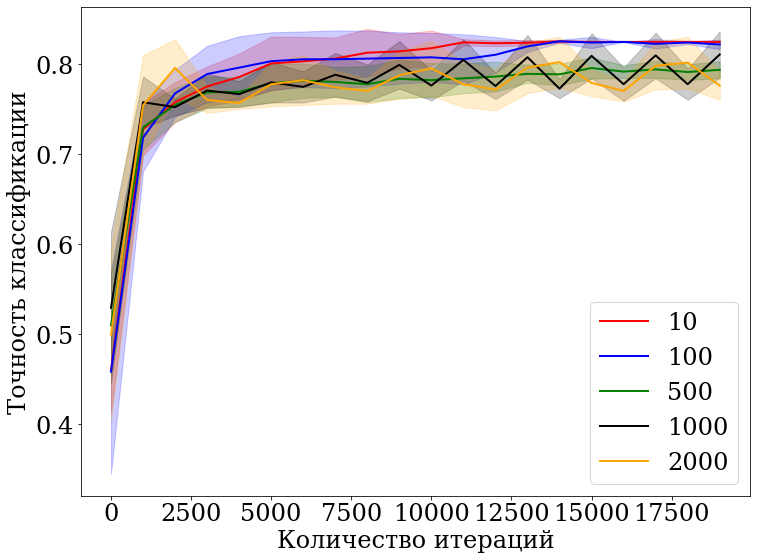

In [6]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_10, '10', 'red')
plot_data(data_100, '100', 'blue')
plot_data(data_500, '500', 'green')
plot_data(data_1000, '1000', 'black')
plot_data(data_2000, '2000', 'orange')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('linear_epoch_size.pdf')
plt.show()

In [7]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

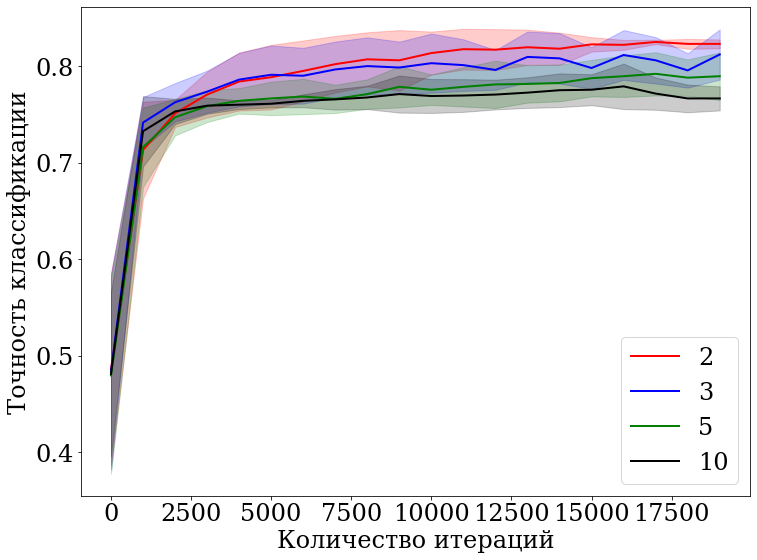

In [8]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_2, '2', 'red')
plot_data(data_3, '3', 'blue')
plot_data(data_5, '5', 'green')
plot_data(data_10, '10', 'black')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('linear_train_splines_every_epoch.pdf')
plt.show()

In [9]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline = [json.loads(line) for line in read_file]
with open("exp1_linear_exp_hyper_opt.jsonl", "r") as read_file:
    data_opt = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_random.jsonl", "r") as read_file:
    data_rand = [json.loads(line) for line in read_file]

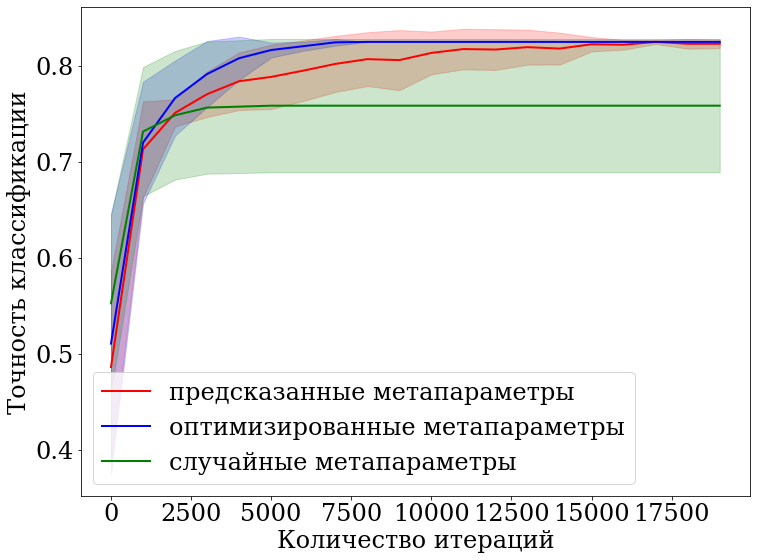

In [10]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_spline, 'предсказанные метапараметры', 'red')
plot_data(data_opt, 'оптимизированные метапараметры', 'blue')
plot_data(data_rand, 'случайные метапараметры', 'green')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('acc_iter.pdf')
plt.show()

In [11]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline2 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_spline3 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_spline5 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_spline10 = [json.loads(line) for line in read_file]

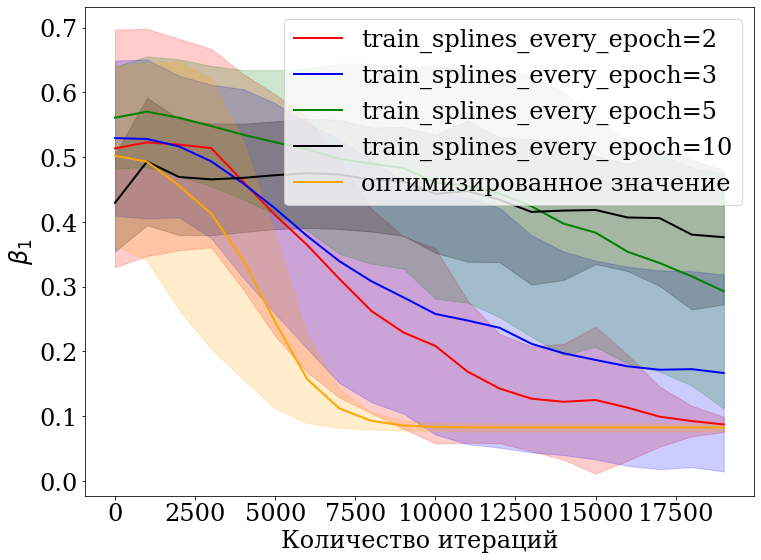

In [12]:
def plot_data_params(data, j, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    par = np.array([subdata[i][j] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_spline2, 2, 'train_splines_every_epoch=2', 'red')
plot_data_params(data_spline3, 2, 'train_splines_every_epoch=3', 'blue')
plot_data_params(data_spline5, 2, 'train_splines_every_epoch=5', 'green')
plot_data_params(data_spline10, 2, 'train_splines_every_epoch=10', 'black')
plot_data_params(data_opt, 2, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('beta1_iter.pdf')
plt.show()

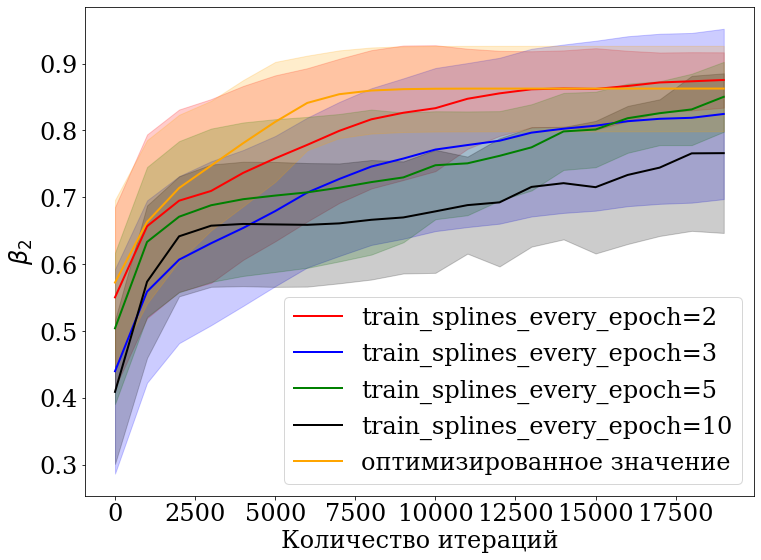

In [13]:
plot_data_params(data_spline2, 3, 'train_splines_every_epoch=2', 'red')
plot_data_params(data_spline3, 3, 'train_splines_every_epoch=3', 'blue')
plot_data_params(data_spline5, 3, 'train_splines_every_epoch=5', 'green')
plot_data_params(data_spline10, 3, 'train_splines_every_epoch=10', 'black')
plot_data_params(data_opt, 3, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('beta2_iter.pdf')
plt.show()

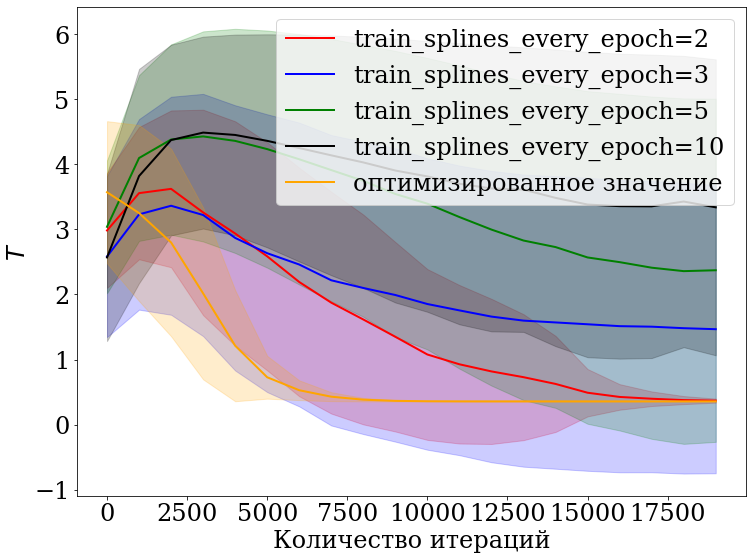

In [14]:
plot_data_params(data_spline2, 4, 'train_splines_every_epoch=2', 'red')
plot_data_params(data_spline3, 4, 'train_splines_every_epoch=3', 'blue')
plot_data_params(data_spline5, 4, 'train_splines_every_epoch=5', 'green')
plot_data_params(data_spline10, 4, 'train_splines_every_epoch=10', 'black')
plot_data_params(data_opt, 4, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('temp_iter.pdf')
plt.show()